<a href="https://colab.research.google.com/github/Olga-1911/Initial-tuning-of-weights-of-fully-connected-and-convolutional-neural-networks/blob/main/%D0%9D%D0%B5%D0%B9%D1%80%D0%BE%D1%81%D0%B5%D1%82%D0%B8_%D0%9B%D0%B0%D0%B1_%D1%80%D0%B0%D0%B1_5_1_%D1%87%D0%B0%D1%81%D1%82%D1%8C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Лабораторная работа № 5**

**Начальная настройка весов полностью связанных
и сверточных нейронных сетей**

Для реализации будут выполнены следующие шаги:

1. Загрузка и обработка набора данных CIFAR-10.

2. Реализация базового FCNN с тремя слоями.

3. Предварительное обучение сети с помощью автоэнкодера.

4. Настройка начальной инициализации весов с помощью RBM.

5. Настройка начальной инициализации весов с помощью алгоритма k-средних.

6. Оценка точности каждой модели и визуализация результатов.

**1. Загрузка и обработка набора данных CIFAR-10.**

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.cluster import KMeans
from sklearn.neural_network import BernoulliRBM
import numpy as np
import matplotlib.pyplot as plt

# Загружаем набор данных CIFAR-10
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

# Нормализация изображений
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

# Преобразуем метки в one-hot encoding
train_labels = to_categorical(train_labels, 10)
test_labels = to_categorical(test_labels, 10)

# Флеттеним изображения для использования в FCNN
train_images_flat = train_images.reshape(-1, 32*32*3)
test_images_flat = test_images.reshape(-1, 32*32*3)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


**2. Реализация базового FCNN с тремя слоями.**

In [ ]:
def create_fcnn(input_shape, num_classes):
    model = Sequential([
        Dense(512, activation='relu', input_shape=(input_shape,)),
        Dropout(0.5),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])  # Тут исправлено lr на learning_rate
    return model

# Создаем модель
base_model = create_fcnn(32*32*3, 10)

# Обучаем базовую модель
history_base = base_model.fit(train_images_flat, train_labels, epochs=15, batch_size=128, validation_split=0.2)

# Тестирование базовой модели
loss_base, acc_base = base_model.evaluate(test_images_flat, test_labels)
print(f"\nBaseline Model Test Accuracy: {acc_base:.4f}\n")

Epoch 1/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 15s 42ms/step - accuracy: 0.1483 - loss: 2.3425 - val_accuracy: 0.2660 - val_loss: 1.9980
Epoch 2/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 41ms/step - accuracy: 0.2138 - loss: 2.0743 - val_accuracy: 0.2870 - val_loss: 1.9700
Epoch 3/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 41ms/step - accuracy: 0.2277 - loss: 2.0346 - val_accuracy: 0.2856 - val_loss: 1.9736
Epoch 4/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 41ms/step - accuracy: 0.2363 - loss: 2.0167 - val_accuracy: 0.3118 - val_loss: 1.9541
Epoch 5/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 41ms/step - accuracy: 0.2434 - loss: 1.9926 - val_accuracy: 0.3055 - val_loss: 1.9524
Epoch 6/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 41ms/step - accuracy: 0.2432 - loss: 1.9952 - val_accuracy: 0.3180 - val_loss: 1.9510
Epoch 7/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 13s 40ms/step - accuracy: 0.2549 - loss: 1.9786 - val_accuracy: 0.3091 - val_loss: 1.9315
Epoch 8/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 41ms/step - accuracy: 0.2570 - loss: 1.9773 - 

**3. Предварительное обучение сети с помощью автоэнкодера.**

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model

# Построим простой автоэнкодер
input_img = Input(shape=(32, 32, 3))

# Encoder
encoded = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
encoded = MaxPooling2D((2, 2))(encoded)

# Decoder
decoded = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
decoded = UpSampling2D((2, 2))(decoded)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(decoded)

# Сборка модели
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Тренировка автоэнкодера
autoencoder.fit(train_images, train_images, epochs=10, batch_size=128, shuffle=True, validation_split=0.2)

# Среднее значение ядер последних фильтров (используется для инициализации)
mean_weight_value = np.mean(autoencoder.layers[-1].get_weights()[0])

# Заполняем первыми весами среднее значение фильтра
first_dense_weights = mean_weight_value * np.ones((32*32*3, 512))

# Модифицируем нашу FCNN-модель, применяя полученные веса
ae_model = create_fcnn(32*32*3, 10)
ae_model.layers[0].set_weights([first_dense_weights, np.zeros(512)])  # Используем среднее значение для инициализации

# Обучаем модель с автоэнкодером
history_ae = ae_model.fit(train_images_flat, train_labels, epochs=15, batch_size=128, validation_split=0.2)

# Тестирование модели с автоэнкодером
loss_ae, acc_ae = ae_model.evaluate(test_images_flat, test_labels)
print(f"\nAE Model Test Accuracy: {acc_ae:.4f}\n")

Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 106s 332ms/step - loss: 0.6013 - val_loss: 0.5582
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 103s 330ms/step - loss: 0.5566 - val_loss: 0.5569
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 142s 330ms/step - loss: 0.5549 - val_loss: 0.5548
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 142s 329ms/step - loss: 0.5535 - val_loss: 0.5542
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 138s 315ms/step - loss: 0.5526 - val_loss: 0.5540
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 150s 340ms/step - loss: 0.5530 - val_loss: 0.5535
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 104s 333ms/step - loss: 0.5527 - val_loss: 0.5534
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 142s 333ms/step - loss: 0.5519 - val_loss: 0.5531
Epoch 9/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 137s 317ms/step - loss: 0.5514 - val_loss: 0.5533
Epoch 10/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 143s 320ms/step - loss: 0.5515 - val_loss: 0.5530
Epoch 1/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 15s 43ms/step - accuracy: 0.0991 - loss: 2.3027 - val_accur

**4. Настройка начальной инициализации весов с помощью RBM.**

In [ ]:
from sklearn.neural_network import BernoulliRBM
import numpy as np

# Настраиваем RBM
rbm = BernoulliRBM(n_components=512, learning_rate=0.01, batch_size=128, n_iter=10, random_state=42)
rbm.fit(train_images_flat)

# Берём компоненты RBM как начальные веса
rbm_weights = rbm.components_.T  # Транспонирование весов

# Генерируем нулевые смещения (так как у RBM нет смещений)
rbm_biases = np.zeros(rbm_weights.shape[1])  # Смещение должно соответствовать выходному слою Dense

# Создаем новую модель с первым слоем Dense
rbm_model = create_fcnn(32 * 32 * 3, 10)

# Устанавливаем полученные веса и смещения
rbm_model.layers[0].set_weights([rbm_weights, rbm_biases])

# Обучение модели с предобученными весами RBM
history_rbm = rbm_model.fit(train_images_flat, train_labels, epochs=15, batch_size=128, validation_split=0.2)

# Оценка качества модели
loss_rbm, acc_rbm = rbm_model.evaluate(test_images_flat, test_labels)
print(f"\nRBM Model Test Accuracy: {acc_rbm:.4f}\n")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.1651 - loss: 2.8534 - val_accuracy: 0.3037 - val_loss: 1.9903
Epoch 2/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 42ms/step - accuracy: 0.2441 - loss: 2.0533 - val_accuracy: 0.3090 - val_loss: 1.9288
Epoch 3/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 41ms/step - accuracy: 0.2644 - loss: 1.9964 - val_accuracy: 0.3282 - val_loss: 1.9189
Epoch 4/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 42ms/step - accuracy: 0.2749 - loss: 1.9620 - val_accuracy: 0.3491 - val_loss: 1.8723
Epoch 5/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 42ms/step - accuracy: 0.2973 - loss: 1.9191 - val_accuracy: 0.3553 - val_loss: 1.8409
Epoch 6/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.3138 - loss: 1.8973 - val_accuracy: 0.3631 - val_loss: 1.8152
Epoch 7/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 13s 42ms/step - accuracy: 0.3169 - loss: 1.8687 - val_accuracy: 0.3683 - val_loss: 1.8365
Epoch 8/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 43ms/step - accuracy: 0.3135 - loss: 1.8750 - 

**5. Настройка начальной инициализации весов с помощью алгоритма k-средних.**

In [ ]:
from sklearn.cluster import KMeans
import numpy as np

# Настраиваем алгоритм k-средних
kmeans = KMeans(n_clusters=512, random_state=42)
kmeans.fit(train_images_flat)

KMeans(n_clusters=512, random_state=42)

In [ ]:
# Центры кластеров как начальные веса
kmeans_weights = kmeans.cluster_centers_.T  # Транспонируем весовую матрицу

In [ ]:
# Создаем вектор смещений (длина равна количеству выходов слоя)
kmeans_biases = np.zeros(kmeans_weights.shape[1])

In [ ]:
# Применяем веса k-средних к нашей модели
kmeans_model = create_fcnn(32*32*3, 10)
kmeans_model.layers[0].set_weights([kmeans_weights, kmeans_biases])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Обучаем модель с начальными весами от k-средних
history_kmeans = kmeans_model.fit(train_images_flat, train_labels, epochs=15, batch_size=128, validation_split=0.2)

Epoch 1/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.0984 - loss: 323.3769 - val_accuracy: 0.0952 - val_loss: 2.3027
Epoch 2/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - accuracy: 0.1003 - loss: 2.4629 - val_accuracy: 0.0952 - val_loss: 2.3027
Epoch 3/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 13s 42ms/step - accuracy: 0.0994 - loss: 2.4184 - val_accuracy: 0.0952 - val_loss: 2.3027
Epoch 4/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 13s 42ms/step - accuracy: 0.0991 - loss: 2.3167 - val_accuracy: 0.0952 - val_loss: 2.3027
Epoch 5/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.0998 - loss: 2.3417 - val_accuracy: 0.0952 - val_loss: 2.3027
Epoch 6/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.0992 - loss: 2.3120 - val_accuracy: 0.0952 - val_loss: 2.3027
Epoch 7/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 42ms/step - accuracy: 0.1021 - loss: 2.3521 - val_accuracy: 0.0952 - val_loss: 2.3027
Epoch 8/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 42ms/step - accuracy: 0.0990 - loss: 2.3064 

In [ ]:
# Проверяем качество модели
loss_kmeans, acc_kmeans = kmeans_model.evaluate(test_images_flat, test_labels)
print(f"\nK-Means Model Test Accuracy: {acc_kmeans:.4f}\n")

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.1006 - loss: 2.3026

K-Means Model Test Accuracy: 0.1000



**6. Оценка точности каждой модели и визуализация результатов.**


Comparison of Validation Accuracies:
----------------------------------------
Base Model: 0.3171
Autoencoder: 0.1000
RBM: 0.4024
K-Means: 0.1000


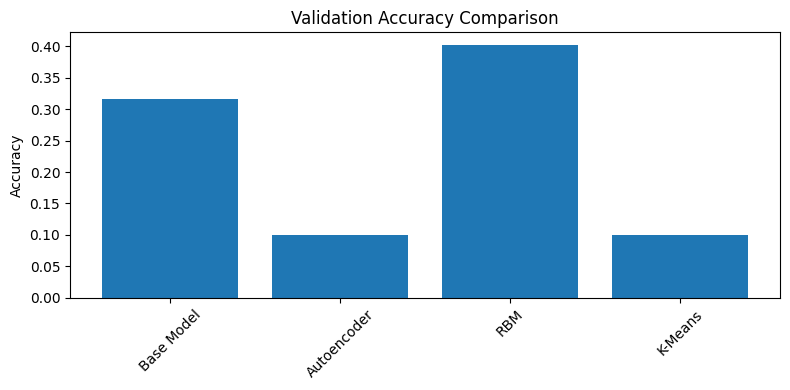

In [ ]:
# Собираем результаты в единый словарь
results = {
    'Base Model': acc_base,
    'Autoencoder': acc_ae,
    'RBM': acc_rbm,
    'K-Means': acc_kmeans
}

# Выводим таблицы результатов
print("\nComparison of Validation Accuracies:")
print("-" * 40)
for method, accuracy in results.items():
    print(f"{method}: {accuracy:.4f}")

# Рисуем график
plt.figure(figsize=(8, 4))
plt.bar(results.keys(), results.values())
plt.title('Validation Accuracy Comparison')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
def plot_training_history(history, title):
    """Визуализация истории обучения."""
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Точность
    axes[0].plot(history.history['accuracy'], label='Training Accuracy')
    axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axes[0].legend(loc='lower right')
    axes[0].set_title(title + ': Training & Validation Accuracy')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Accuracy')

    # Потеря
    axes[1].plot(history.history['loss'], label='Training Loss')
    axes[1].plot(history.history['val_loss'], label='Validation Loss')
    axes[1].legend(loc='upper right')
    axes[1].set_title(title + ': Training & Validation Loss')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Loss')

    plt.show()

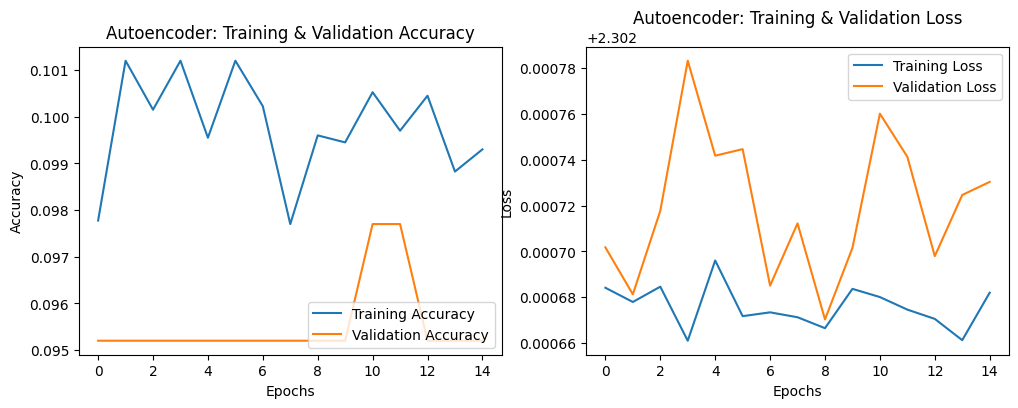

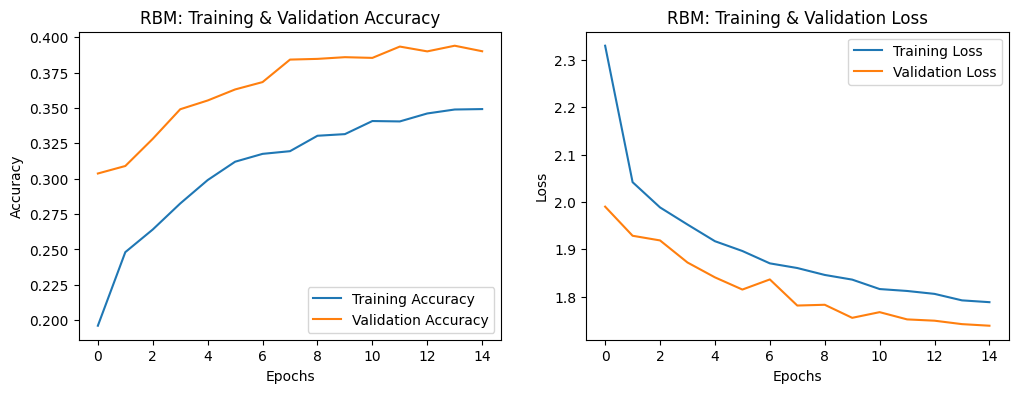

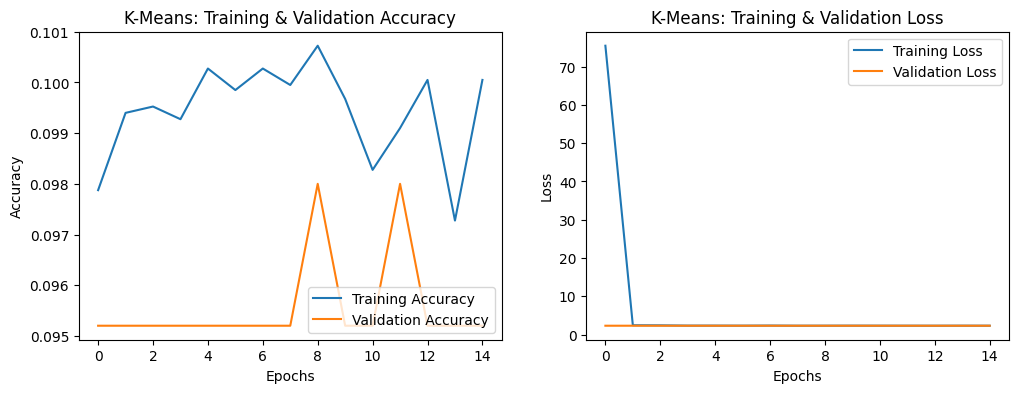

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step


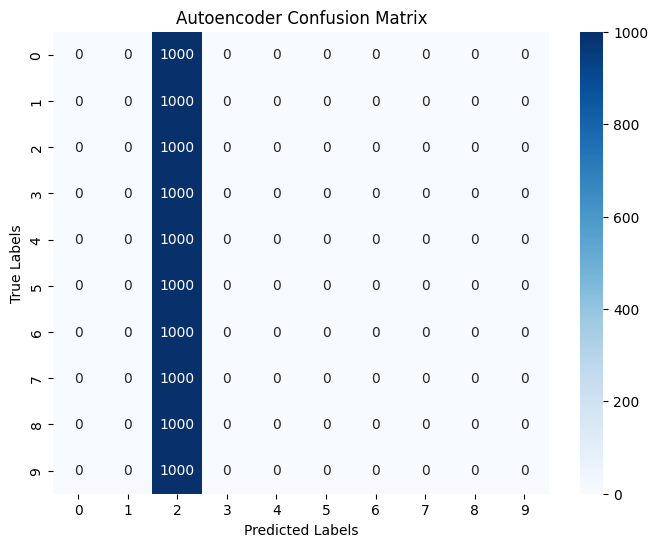

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


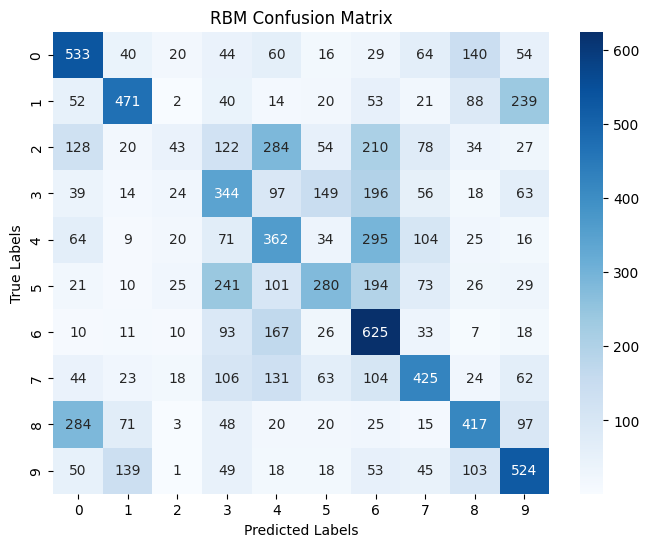

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step


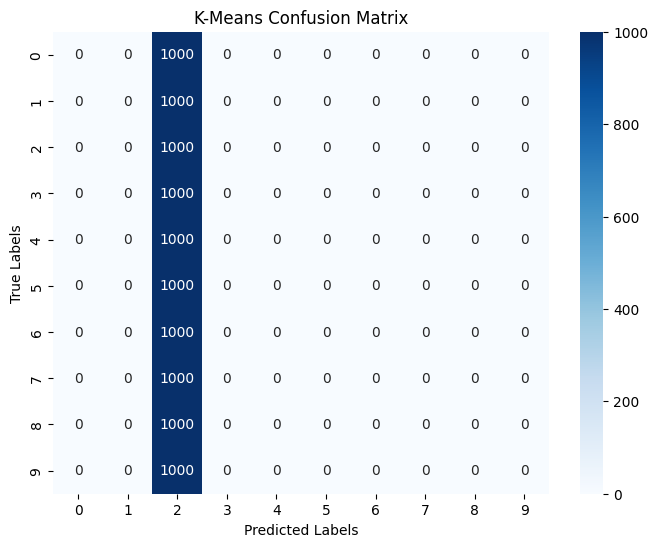

In [ ]:
# Автоэнкодер
plot_training_history(history_ae, 'Autoencoder')

# RBM
plot_training_history(history_rbm, 'RBM')

# K-Means
plot_training_history(history_kmeans, 'K-Means')

# === ВИЗУАЛИЗАЦИЯ МАТРИЦЫ ОШИБОК ===
def plot_confusion_matrix(model, x_test, y_test, title):
    """Визуализация матрицы ошибок."""
    # Привести x_test к плоской форме, соответствующей той, которая использовалась при обучении
    x_test_flat = x_test.reshape((-1, 32*32*3))

    pred = model.predict(x_test_flat)
    predicted_labels = np.argmax(pred, axis=1)
    true_labels = np.argmax(y_test, axis=1)

    cm = confusion_matrix(true_labels, predicted_labels)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(title)
    plt.show()

# === ПОКАЖЕМ МАТРИЦЫ ОШИБОК ===
# Автоэнкодер
plot_confusion_matrix(ae_model, test_images, test_labels, 'Autoencoder Confusion Matrix')

# RBM
plot_confusion_matrix(rbm_model, test_images, test_labels, 'RBM Confusion Matrix')

# K-Means
plot_confusion_matrix(kmeans_model, test_images, test_labels, 'K-Means Confusion Matrix')